# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Kristoffer Landsnes & Arthur ...
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [43]:
import tarfile
import os
import cv2
import numpy as np
import skimage.segmentation as seg
import skimage.color as color


data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

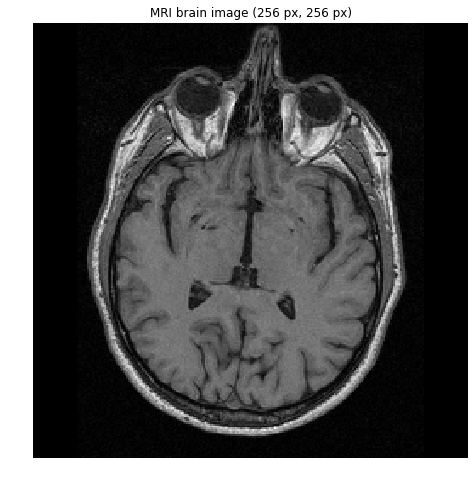

In [3]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing


### REGION GROWING USING THRESHOLD

In [4]:
def get_neighbors(px, img):
    """return list of the neighbors of px (x,y) in img"""

    px_x, px_y = px[0], px[1]
    height = len(img)
    width = len(img[0])
    
    # Check that px is within the bounds of the img
    assert px_x < height
    assert px_y < width
    
    neighbors = []
    
    # North-West
    if px_x > 0 and px_y > 0:
        neighbors.append((px_x - 1, px_y - 1))
            
    # North
    if px_x > 0:
        neighbors.append((px_x - 1, px_y))
        
    # North-East
    if px_x > 0 and px_y < width:
        neighbors.append((px_x - 1, px_y + 1))
            
    # West
    if px_y > 0:
        neighbors.append((px_x, px_y - 1))

    # East
    if px_y < width:
        neighbors.append((px_x, px_y + 1))
            
    # South-West
    if px_x < height and px_y > 0:
        neighbors.append((px_x + 1, px_y - 1))
            
    # South
    if px_x < height:
        neighbors.append((px_x + 1, px_y))
            
    # South-East
    if px_x < height and px_y < width:
        neighbors.append((px_x + 1, px_y + 1))
            
    return neighbors
    

In [5]:
def get_thresholded_neighbors(th, px, img):
    "returns a list of the neighbors of px (x,y) in img whose px_value is above a threshold"
    neighbors = get_neighbors(px, img)
    good_neighbords = []
    
    for px in neighbors:
        if img[px] > th:
            good_neighbords.append(px)
        
    return neighbors

In [6]:
def region_growing(seed_x, seed_y, th, img):
    "region growing using the pixel_value > threshold as a homogeneity criterion"
    
    height = len(img)
    width = len(img[0])
    
    # Check that the seed is within the bounds of the img
    assert seed_x < height
    assert seed_y < width
    
    # labeled_img[x][y] if the (x,y) pixel hasn't been visited yet,
    # 1 if it has been visited and is ABOVE th
    # -1 if it has been visited and is BELOW th
    labeled_img = np.zeros((height, width))
    
    # list of the pixels left to visit
    px_to_visit = [(seed_x, seed_y)]
    
    for px in px_to_visit:
        
        if labeled_img[px] == 0:
            # see if px belongs to the region
            if img[px] > th:
                labeled_img[px] = 1
                # add the neighbors of px to the px_to_visit if they should be added
                px_to_visit.extend(get_thresholded_neighbors(th, px, img))
            else:
                labeled_img[px] = -1    
        
    return labeled_img

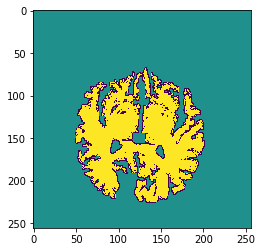

In [23]:
a = region_growing(100,100,69,brain_im) # 69 has been set empirically
plt.imshow(a)


In [8]:
# Sensitivity to the seed

# Sensitivity to the threshold

In [9]:
# Hence the size of the brain is the sum of all the pixels in the grown regions
count = 0
for x in a.ravel():
    if x == 1:
        count = count + 1

print("There are " + str(count) + " pixels in the brain") 

There are 12062 pixels in the brain


## 1.3 Contour detection
Add your implementation and discussion

Text(0.5, 1.0, 'hildreth')

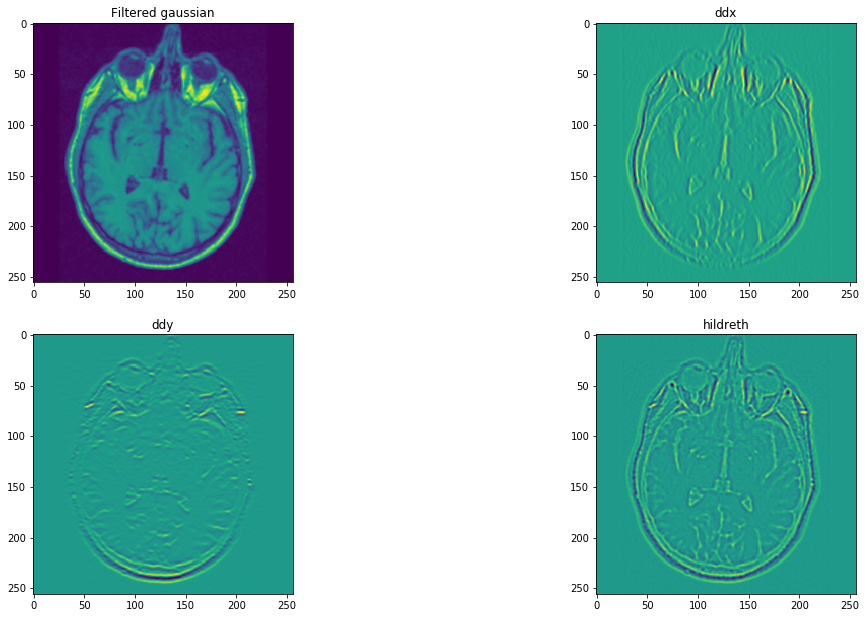

In [28]:
# Marr-Hildreths method 
def gaussian_filter(fSize, fSigma):
    x, y = np.mgrid[-fSize//2 + 1:fSize//2 + 1, -fSize//2 + 1:fSize//2 + 1]
    #print(x)
    g = np.exp(-((x**2 + y**2)/(2.0*fSigma**2)))
    return g/g.sum()


gaus = gaussian_filter(3,2)
filtered_brain = cv2.filter2D(brain_im, -1, gaus)

#Compute gradient in x-direction of picture
brain_dx = cv2.Sobel(np.float32(filtered_brain), cv2.CV_32F,1,0) #Last two numbers = dx, dy 
brain_ddx = cv2.Sobel(np.float32(brain_dx), cv2.CV_32F,1,0) #Last two numbers = dx, dy 
#Compute gradient in y-direction
brain_dy = cv2.Sobel(np.float32(filtered_brain), cv2.CV_32F,0,1) #Last two numbers = dx, dy 
brain_ddy = cv2.Sobel(np.float32(brain_dy), cv2.CV_32F,0,1) #Last two numbers = dx, dy 

brain_hildreth = brain_ddy + brain_ddx

fig, axes = plt.subplots(2, 2, figsize=(6, 6))
fig.set_size_inches(18.5, 10.5)
axes[0][0].imshow(filtered_brain)
axes[0][0].set_title('Filtered gaussian')
axes[0][1].imshow(brain_ddx)
axes[0][1].set_title('ddx')
axes[1][0].imshow(brain_ddy)
axes[1][0].set_title('ddy')
axes[1][1].imshow(brain_hildreth)
axes[1][1].set_title('hildreth')
#gaus_img = skimage.filters.gaussian(brain_im, sigma=3)
#plt.imshow(gaus_img, cmap=plt.cm.gray)


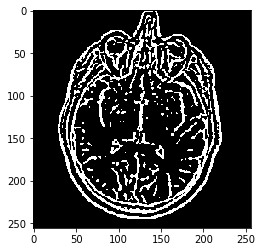

In [11]:
retval, thresholded = cv2.threshold(brain_hildreth, 180, 200, cv2.THRESH_BINARY)
plt.imshow(thresholded, cmap = plt.cm.gray)


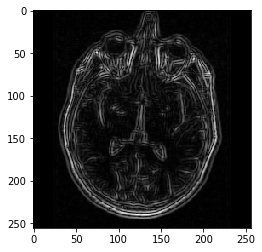

In [12]:
#calculate magnitude 
#ACTIVE CONTOURS 
#FIND CONTOURS - DELETE SOME OF SKULL / EYES - AREA OF CONTOURS(?)
#
grad_mag = np.sqrt(brain_ddx**2 + brain_ddy**2)
plt.imshow(grad_mag, cmap = plt.cm.gray)

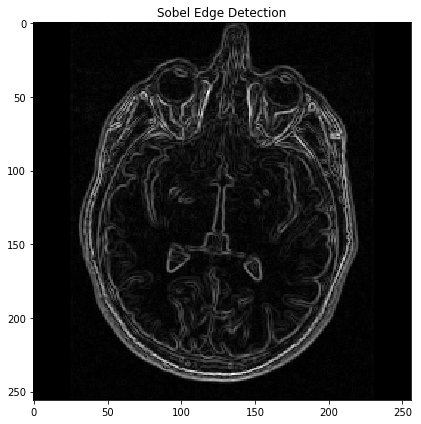

In [13]:
#Sobel filtering 

edge_sobel = skimage.filters.sobel(brain_im)

plt.figure(figsize = (6,6))
plt.imshow(edge_sobel, cmap=plt.cm.gray)
plt.title('Sobel Edge Detection')
plt.tight_layout()
plt.show()

#Apply regiongrowing from the centre, with new contours 

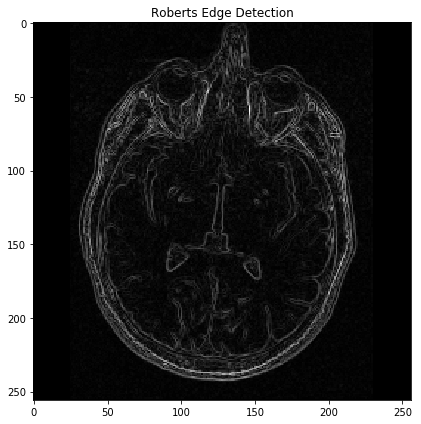

In [14]:
# Roberts filtering 
edge_sobel = skimage.filters.roberts(brain_im)

plt.figure(figsize = (6,6))
plt.imshow(edge_sobel, cmap=plt.cm.gray)
plt.title('Roberts Edge Detection')
plt.tight_layout()
plt.show()

### 1.4 Additional method(s)
Will start with this, as easy methods can be implemented for visualization. 


### 1.5 tresholding
Assumes brain size is bright area of brain, not dark

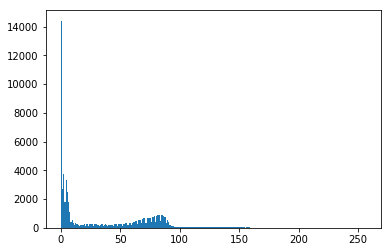

In [15]:
# Histogram thresholding for identifying the brain area 
plt.hist(brain_im.ravel(), 256,[0,256])
plt.show()


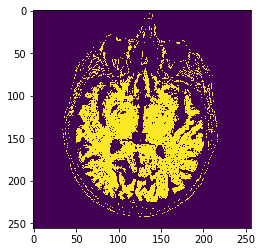

In [30]:
#Tresholding to keep most of the brain as foreground
t1 = 70
t2 = 90

brain_treshold = brain_im.copy()
brain_treshold[brain_treshold<t1] = 0
brain_treshold[brain_treshold>t2] = 0
brain_treshold[(brain_treshold>=t1) & (brain_treshold<=t2)] = 255

plt.imshow(brain_treshold)
#plt.imshow(brain_treshold[75:175,100:200])


The total pixels of the brain is estimated to be 9685


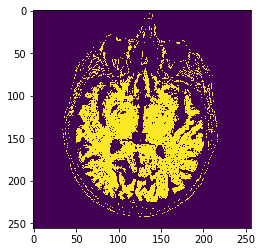

In [17]:
plt.imshow(brain_treshold)
#This is very simple, but also an estimation 
#Sum all pixels of value 255 from the square starting at (55,75),(55,200), (200,75),(200,200)

estimated_brain = brain_treshold[55:200, 75:200]
high_values = estimated_brain[estimated_brain > 0]
total_pixels_estimated = len(high_values)
print('The total pixels of the brain is estimated to be', total_pixels_estimated)

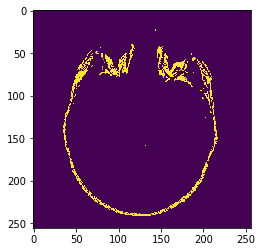

In [18]:
#Different method
t1 = 100
t2 = 150

brain_treshold = brain_im.copy()
brain_treshold[brain_treshold<t1] = 0
brain_treshold[brain_treshold>t2] = 0
brain_treshold[(brain_treshold>=t1) & (brain_treshold<=t2)] = 255

plt.imshow(brain_treshold)



## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [33]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


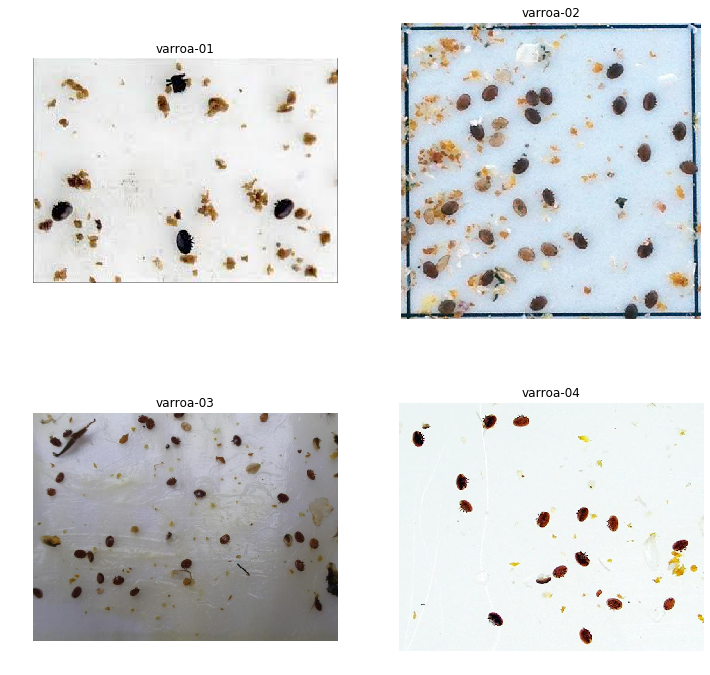

In [34]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [35]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [36]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

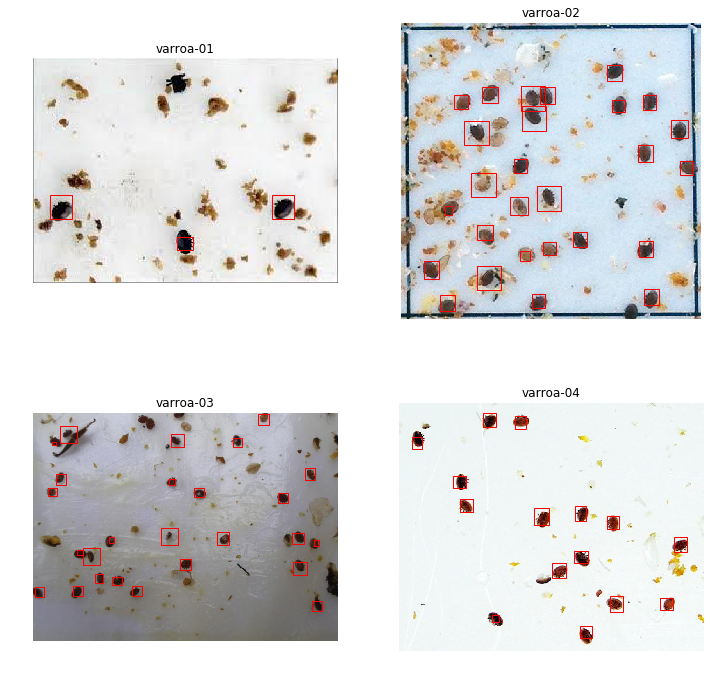

In [37]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

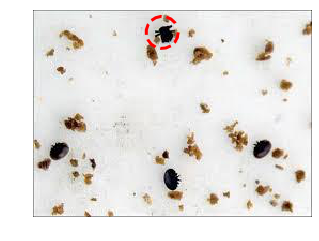

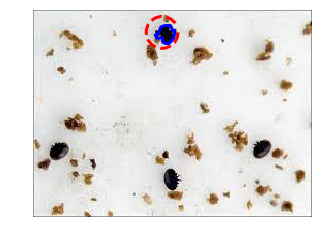

In [75]:
#annotations_xmls
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

def circle_points(resolution, center, radius):
    """
    Generate points which define a circle on an image.Centre refers to the centre of the circle
    """   
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)#polar co-ordinates
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T
# Exclude last point because a closed path should not have duplicate points
points = circle_points(20, [20, 120], 15)[:-1]


fig, ax = image_show(ic[0])
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
image_gray = color.rgb2gray(ic[0])

snake = seg.active_contour(image_gray, points)
fig, ax = image_show(ic[0])
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

4


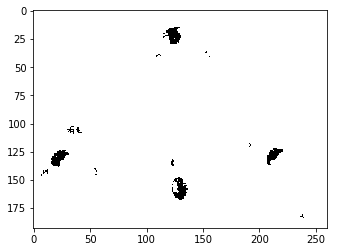

In [165]:
#Test for tresholding picture with "optimal treshold"
gray_im = color.rgb2gray(ic[0])
plt.imshow(gray_im)

thresh = skimage.filters.threshold_otsu(gray_im)

binary = gray_im > thresh-0.55
plt.imshow(binary, cmap=plt.cm.gray)

labeled_im = skimage.measure.label(binary, background=True)

number_labels = np.unique(labeled_im[labeled_im!=0])
occurences = np.zeros(len(number_labels))
for ix, number in enumerate(number_labels): 
        occurences[ix] = len(labeled_im[labeled_im==number])

avg_occurence = np.mean(occurences) #Can easily change this criteria to rather check for all neighbors > 10 pixels etc.
counted_creatures = len(occurences[occurences>avg_occurence])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


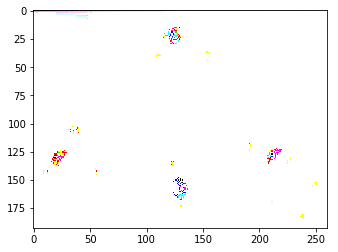

In [129]:
#Count centers -> Treshold and find areas with black relative circles 

def count_centers(gray_im):
    r,c = (gray_im.shape)
    
    


gray_im = color.rgb2gray(ic[0])
#count_centers(gray_im)
#plt.hist(gray_im.ravel(), 256,[0,256])
labeled_im = skimage.measure.label(ic[0])
plt.imshow(labeled_im)
#print(labeled_im[labeled_im>0])


### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

[5]


### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion